In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [3]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [4]:
# Shuffle data set
indices = list(range(len(X)))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

In [5]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

X_train -= 127
X_train /= 127

X_test  -= 127
X_test /= 127

In [6]:
X_test.shape
y.shape

(42000, 1)

In [7]:
import tensorflow as tf

def dense(input_size, output_size, mean=0.0, stddev=0.01, dtype=tf.float32, activation_type=None):
    weight_tensor = tf.Variable(tf.random_normal(shape=(input_size, output_size),
                                                mean=mean, stddev=stddev, dtype=dtype))
    
    bias_tensor = tf.Variable(tf.zeros(output_size))
    
    def apply_dense(X, keep_prob):
        result = tf.add(tf.matmul(X, weight_tensor), bias_tensor)
        return tf.layers.dropout(activation_type(result), rate=1-keep_prob, training=True) if activation_type != None else tf.layers.dropout(result, rate=1-keep_prob, training=True)

    return apply_dense
        

/home/safwan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
def combine(tensor_one, tensor_two):
    return tf.div(tf.add(tensor_one, tensor_two), 2)

In [9]:
input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))
learning_rate_ph = tf.placeholder(dtype=tf.float32)
keep_prob = tf.placeholder(dtype=tf.float32)

In [43]:
def nn():
    
    #l1 = dense(int(input_.shape[1]), 64, activation_type=tf.nn.relu)(input_, keep_prob)
    input_2d = tf.reshape(input_,[-1,28,28,1])
    l1_1 = tf.layers.conv2d(input_2d,32,5,1,activation=tf.nn.relu)
    l1_2 = tf.layers.max_pooling2d(l1_1,2,2)
    l1_3 = tf.layers.dropout(l1_2, rate=keep_prob*0.5)
    
    l1_4 = tf.layers.conv2d(l1_3,16,5,1,activation=tf.nn.relu)
    l1_5 = tf.layers.max_pooling2d(l1_4,2,2)
    
    l1_6 = tf.layers.flatten(l1_5)
    
    l2 = dense(int(l1_6.shape[1]), 32, activation_type=tf.nn.relu)(l1_6, keep_prob)
    out = dense(int(l2.shape[1]), 10)(l2, keep_prob)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return cost, optimizer, out

In [44]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [45]:
cost, optimizer, output = nn()

In [46]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 50
batch_size = 64
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []
test_accuracy = []
cost_curr = []

def eval_cost(X, y):
    total_cost = 0
    nb_batches = 0
    for X,y in get_next_batch(256,X,y):
        feed_dict={input_: X, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0}
        total_cost += cost.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches

def eval_accuracy(X,y):
    nb_batches = 0
    total_acc = 0
    for X,y in get_next_batch(256,X,y):
        feed_dict={input_: X, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0}
        y_predicted = np.argmax(output.eval(feed_dict=feed_dict),1)
        total_acc += accuracy_score(y,y_predicted)
        nb_batches += 1
    return total_acc/nb_batches
        

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #graph = tf.get_default_graph().as_graph_def()
    #print([n for n in graph.node])
    
    #plt.ion()
    # Training cycle
    current_placeholder_value = 0.001
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={input_:x, labels:y, learning_rate_ph:current_placeholder_value, keep_prob:0.7})
        
        
        if (epoch+1) % 1 == 0:
            # Find training cost.
            c = eval_cost(X_train_fold, y_train_fold)
            cost_curr.append(c)
            # Find train accuracy
            current_train_acc = eval_accuracy(X_train_fold,y_train_fold)
            train_accuracy.append(current_train_acc)
            # Find the validation accuracy
            current_val_acc = eval_accuracy(X_val_fold, y_val_fold)
            val_accuracy.append(current_val_acc)
            # Find test accuracy
            test_acc = eval_accuracy(X_test, y_test)
            test_accuracy.append(test_acc)
            
            
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            print("Train Accuracy:", current_train_acc)
            print("Validation Accuracy:", current_val_acc)
            print("Test Accuracy:",test_acc)
            print()
            
            if test_acc > 0.99:
                saver = tf.train.Saver()
                saver.save(sess,'./mnist-acc{}'.format(test_acc*100.0),global_step=epoch+1)
              
    
    print("Optimization Finished!")
    # Find test accuracy
    print("Test Accuracy:",eval_accuracy(X_test, y_test) )



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:19<16:12, 19.85s/it]

Epoch: 0001 cost= 0.154502199
Train Accuracy: 0.958203125
Validation Accuracy: 0.9168526785714286
Test Accuracy: 0.8888346354166666





  4%|▍         | 2/50 [00:43<17:35, 22.00s/it]

Epoch: 0002 cost= 0.105438970
Train Accuracy: 0.9625434027777777
Validation Accuracy: 0.9246651785714286
Test Accuracy: 0.9369303385416666





  6%|▌         | 3/50 [01:23<21:55, 27.99s/it]

Epoch: 0003 cost= 0.056019692
Train Accuracy: 0.9832899305555556
Validation Accuracy: 0.9389880952380952
Test Accuracy: 0.9278971354166666





  8%|▊         | 4/50 [01:44<19:57, 26.03s/it]

Epoch: 0004 cost= 0.024845477
Train Accuracy: 0.9959201388888889
Validation Accuracy: 0.9408482142857143
Test Accuracy: 0.9659830729166666





 10%|█         | 5/50 [02:04<18:38, 24.86s/it]

Epoch: 0005 cost= 0.047375179
Train Accuracy: 0.9788628472222223
Validation Accuracy: 0.9601934523809523
Test Accuracy: 0.94873046875





 12%|█▏        | 6/50 [02:27<18:00, 24.55s/it]

Epoch: 0006 cost= 0.039055164
Train Accuracy: 0.9944010416666667
Validation Accuracy: 0.9540550595238095
Test Accuracy: 0.9544270833333334





 14%|█▍        | 7/50 [02:59<18:20, 25.59s/it]

Epoch: 0007 cost= 0.009989130
Train Accuracy: 0.9976996527777777
Validation Accuracy: 0.9525669642857143
Test Accuracy: 0.9654947916666666





 16%|█▌        | 8/50 [03:18<17:23, 24.85s/it]

Epoch: 0008 cost= 0.022344630
Train Accuracy: 0.9939236111111112
Validation Accuracy: 0.9572172619047619
Test Accuracy: 0.9652506510416666





 18%|█▊        | 9/50 [03:38<16:35, 24.27s/it]

Epoch: 0009 cost= 0.023525081
Train Accuracy: 0.98828125
Validation Accuracy: 0.9557291666666666
Test Accuracy: 0.9679361979166666





 20%|██        | 10/50 [04:04<16:16, 24.40s/it]

Epoch: 0010 cost= 0.013160448
Train Accuracy: 0.99609375
Validation Accuracy: 0.96484375
Test Accuracy: 0.9703776041666666





 22%|██▏       | 11/50 [04:33<16:10, 24.88s/it]

Epoch: 0011 cost= 0.006948694
Train Accuracy: 0.9990885416666667
Validation Accuracy: 0.9620535714285714
Test Accuracy: 0.9649251302083334





 24%|██▍       | 12/50 [04:53<15:29, 24.46s/it]

Epoch: 0012 cost= 0.018589914
Train Accuracy: 0.9950086805555556
Validation Accuracy: 0.96484375
Test Accuracy: 0.9724934895833334





 26%|██▌       | 13/50 [05:13<14:52, 24.13s/it]

Epoch: 0013 cost= 0.000584152
Train Accuracy: 1.0
Validation Accuracy: 0.98828125
Test Accuracy: 0.978759765625





 28%|██▊       | 14/50 [05:39<14:33, 24.27s/it]

Epoch: 0014 cost= 0.053940479
Train Accuracy: 0.9899305555555555
Validation Accuracy: 0.9596354166666666
Test Accuracy: 0.970703125





 30%|███       | 15/50 [06:10<14:25, 24.73s/it]

Epoch: 0015 cost= 0.007186589
Train Accuracy: 1.0
Validation Accuracy: 0.9845610119047619
Test Accuracy: 0.965087890625





 32%|███▏      | 16/50 [06:31<13:51, 24.45s/it]

Epoch: 0016 cost= 0.004181084
Train Accuracy: 1.0
Validation Accuracy: 0.9869791666666666
Test Accuracy: 0.97412109375





 34%|███▍      | 17/50 [06:51<13:18, 24.20s/it]

Epoch: 0017 cost= 0.011814173
Train Accuracy: 0.9953559027777777
Validation Accuracy: 0.9466145833333334
Test Accuracy: 0.9654947916666666





 36%|███▌      | 18/50 [07:16<12:55, 24.25s/it]

Epoch: 0018 cost= 0.001426646
Train Accuracy: 1.0
Validation Accuracy: 0.9585193452380952
Test Accuracy: 0.9607747395833334





 38%|███▊      | 19/50 [07:45<12:38, 24.48s/it]

Epoch: 0019 cost= 0.006594180
Train Accuracy: 0.9990885416666667
Validation Accuracy: 0.9774925595238095
Test Accuracy: 0.96728515625





 40%|████      | 20/50 [08:05<12:07, 24.26s/it]

Epoch: 0020 cost= 0.016372141
Train Accuracy: 0.9942708333333333
Validation Accuracy: 0.9966517857142857
Test Accuracy: 0.9638671875





 42%|████▏     | 21/50 [08:25<11:37, 24.06s/it]

Epoch: 0021 cost= 0.010340338
Train Accuracy: 0.99609375
Validation Accuracy: 0.9758184523809523
Test Accuracy: 0.9798990885416666





 44%|████▍     | 22/50 [08:48<11:13, 24.04s/it]

Epoch: 0022 cost= 0.006738165
Train Accuracy: 0.9963107638888888
Validation Accuracy: 0.9786086309523809
Test Accuracy: 0.9715983072916666





 46%|████▌     | 23/50 [09:19<10:56, 24.32s/it]

Epoch: 0023 cost= 0.033675381
Train Accuracy: 0.9860243055555555
Validation Accuracy: 0.9681919642857143
Test Accuracy: 0.9805501302083334





 48%|████▊     | 24/50 [09:39<10:27, 24.13s/it]

Epoch: 0024 cost= 0.000822535
Train Accuracy: 1.0
Validation Accuracy: 0.953125
Test Accuracy: 0.9768880208333334





 50%|█████     | 25/50 [09:58<09:58, 23.94s/it]

Epoch: 0025 cost= 0.010126502
Train Accuracy: 0.9954427083333334
Validation Accuracy: 0.9691220238095238
Test Accuracy: 0.966552734375





 52%|█████▏    | 26/50 [10:18<09:30, 23.78s/it]

Epoch: 0026 cost= 0.008226493
Train Accuracy: 0.9970486111111111
Validation Accuracy: 0.9895833333333334
Test Accuracy: 0.9828287760416666





 54%|█████▍    | 27/50 [10:46<09:10, 23.95s/it]

Epoch: 0027 cost= 0.002663743
Train Accuracy: 0.9978298611111112
Validation Accuracy: 0.9866071428571429
Test Accuracy: 0.9828287760416666

Epoch: 0028 cost= 0.003253262
Train Accuracy: 1.0
Validation Accuracy: 0.9921875
Test Accuracy: 0.991455078125





 56%|█████▌    | 28/50 [11:11<08:47, 23.99s/it]

Epoch: 0029 cost= 0.000379871
Train Accuracy: 1.0
Validation Accuracy: 0.9750744047619048
Test Accuracy: 0.9937337239583334





 58%|█████▊    | 29/50 [11:32<08:21, 23.89s/it]

 60%|██████    | 30/50 [11:52<07:55, 23.76s/it]

Epoch: 0030 cost= 0.000342167
Train Accuracy: 1.0
Validation Accuracy: 0.9808407738095238
Test Accuracy: 0.9788411458333334





 62%|██████▏   | 31/50 [12:21<07:34, 23.92s/it]

Epoch: 0031 cost= 0.011156503
Train Accuracy: 0.9964409722222223
Validation Accuracy: 0.9858630952380952
Test Accuracy: 0.9763997395833334





 64%|██████▍   | 32/50 [12:47<07:11, 24.00s/it]

Epoch: 0032 cost= 0.004613912
Train Accuracy: 0.9988715277777778
Validation Accuracy: 0.9644717261904762
Test Accuracy: 0.9740397135416666





 66%|██████▌   | 33/50 [13:07<06:45, 23.87s/it]

Epoch: 0033 cost= 0.006474247
Train Accuracy: 1.0
Validation Accuracy: 0.9806547619047619
Test Accuracy: 0.988037109375





 68%|██████▊   | 34/50 [13:26<06:19, 23.74s/it]

Epoch: 0034 cost= 0.000682995
Train Accuracy: 1.0
Validation Accuracy: 0.96484375
Test Accuracy: 0.9869791666666666





 70%|███████   | 35/50 [13:51<05:56, 23.74s/it]

Epoch: 0035 cost= 0.008200634
Train Accuracy: 0.9967881944444444
Validation Accuracy: 0.9780505952380952
Test Accuracy: 0.97998046875

Epoch: 0036 cost= 0.002211613
Train Accuracy: 1.0
Validation Accuracy: 0.98046875
Test Accuracy: 0.991455078125





 72%|███████▏  | 36/50 [14:18<05:33, 23.83s/it]

 74%|███████▍  | 37/50 [14:37<05:08, 23.73s/it]

Epoch: 0037 cost= 0.003142291
Train Accuracy: 1.0
Validation Accuracy: 0.9873511904761905
Test Accuracy: 0.9737141927083334





 76%|███████▌  | 38/50 [14:58<04:43, 23.63s/it]

Epoch: 0038 cost= 0.006280551
Train Accuracy: 0.9959201388888889
Validation Accuracy: 0.9873511904761905
Test Accuracy: 0.98388671875





 78%|███████▊  | 39/50 [15:26<04:21, 23.75s/it]

Epoch: 0039 cost= 0.000904606
Train Accuracy: 0.999609375
Validation Accuracy: 0.97265625
Test Accuracy: 0.9899088541666666





 80%|████████  | 40/50 [15:45<03:56, 23.64s/it]

Epoch: 0040 cost= 0.022539726
Train Accuracy: 0.9938368055555555
Validation Accuracy: 0.9921875
Test Accuracy: 0.9844563802083334





 82%|████████▏ | 41/50 [16:06<03:32, 23.58s/it]

Epoch: 0041 cost= 0.001411534
Train Accuracy: 1.0
Validation Accuracy: 0.9765625
Test Accuracy: 0.989501953125





 84%|████████▍ | 42/50 [16:38<03:10, 23.78s/it]

Epoch: 0042 cost= 0.010799295
Train Accuracy: 0.9955729166666667
Validation Accuracy: 0.9827008928571429
Test Accuracy: 0.986083984375





 86%|████████▌ | 43/50 [16:58<02:45, 23.68s/it]

Epoch: 0043 cost= 0.024860999
Train Accuracy: 0.99609375
Validation Accuracy: 0.98828125
Test Accuracy: 0.9768880208333334





 88%|████████▊ | 44/50 [17:17<02:21, 23.58s/it]

Epoch: 0044 cost= 0.011934884
Train Accuracy: 0.991796875
Validation Accuracy: 0.98046875
Test Accuracy: 0.973876953125





 90%|█████████ | 45/50 [17:38<01:57, 23.53s/it]

Epoch: 0045 cost= 0.025049298
Train Accuracy: 0.99609375
Validation Accuracy: 0.98046875
Test Accuracy: 0.987548828125





 92%|█████████▏| 46/50 [18:16<01:35, 23.83s/it]

Epoch: 0046 cost= 0.004584145
Train Accuracy: 0.9962673611111111
Validation Accuracy: 0.9880952380952381
Test Accuracy: 0.9854329427083334





 94%|█████████▍| 47/50 [18:35<01:11, 23.73s/it]

Epoch: 0047 cost= 0.017932445
Train Accuracy: 0.9921875
Validation Accuracy: 0.96484375
Test Accuracy: 0.9814453125





 96%|█████████▌| 48/50 [18:54<00:47, 23.64s/it]

Epoch: 0048 cost= 0.000190123
Train Accuracy: 1.0
Validation Accuracy: 0.98828125
Test Accuracy: 0.9847005208333334

Epoch: 0049 cost= 0.000678439
Train Accuracy: 1.0
Validation Accuracy: 0.9704241071428571
Test Accuracy: 0.990966796875





 98%|█████████▊| 49/50 [19:15<00:23, 23.57s/it]

100%|██████████| 50/50 [19:34<00:00, 23.49s/it]



Epoch: 0050 cost= 0.013195562
Train Accuracy: 0.9963541666666667
Validation Accuracy: 0.9867931547619048
Test Accuracy: 0.9869791666666666

Optimization Finished!
Test Accuracy: 0.9869791666666666


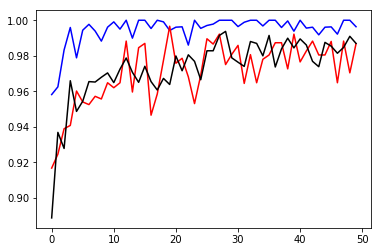

In [47]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-', test_accuracy,'k-')
plt.show()

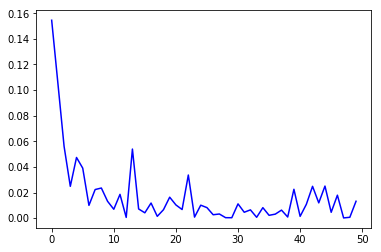

In [48]:
plt.plot(cost_curr, 'b-')
plt.show()

In [141]:
from sklearn.metrics import confusion_matrix

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    # Find out the predictions
    y_predicted_test = []
    # Training cycle
    current_placeholder_value = 0.001
    
    nb_batches = 0
    total_acc = 0
    
    for X,y in get_next_batch(256,X_test,y_test):
        feed_dict={input_: X, labels: y, keep_prob:1.0}
        y_predict = np.argmax(output.eval(feed_dict=feed_dict),1)
        
        batch_acc = accuracy_score(y,y_predict)
        total_acc += batch_acc
        y_predicted_test.append(y_predict)
        #print(confusion_matrix(y_true=y, y_pred=y_predict))
        #print(batch_acc)
        nb_batches += 1

    #print(total_acc/nb_batches)
    #flatten = [item for sublist in y_predicted_test for item in sublist]
    
    # Find the prediction for indices not cover by get_next_batch
    #feed_dict={input_: X_test[-(y_test.shape[0]-len(flatten)):], labels: y_test[-(y_test.shape[0]-len(flatten)):], keep_prob:1.0}
    #y_predicted_test.append(np.argmax(output.eval(feed_dict=feed_dict),1))
    
    #flatten = [item for sublist in y_predicted_test for item in sublist]
    
    flat = np.array(flatten).reshape(-1,1)
    conf_matrix = confusion_matrix(y_true=y_test[:-(y_test.shape[0]-len(flatten))], y_pred=y_test[:-(y_test.shape[0]-len(flatten))])
    
    # Write predicted values to file in csv format
    #out_index = np.array(list(range(1,len(flatten)+1)))
    #data = pd.DataFrame({'Label': y_final_predicted_test})
    
    # Start index from 1
    #data.index += 1
    #data.to_csv('./predictions_cnn.csv', index_label=['ImageId'])
    
    print(100*eval_accuracy(X_test, y_test))
    
print(conf_matrix)
print(y_test.shape)
print(flat.shape)

INFO:tensorflow:Restoring parameters from ./mnist-acc99.0966796875-49
99.0966796875
[[1182    0    0    0    0    0    0    0    0    0]
 [   0 1411    0    0    0    0    0    0    0    0]
 [   0    0 1219    0    0    0    0    0    0    0]
 [   0    0    0 1302    0    0    0    0    0    0]
 [   0    0    0    0 1207    0    0    0    0    0]
 [   0    0    0    0    0 1058    0    0    0    0]
 [   0    0    0    0    0    0 1218    0    0    0]
 [   0    0    0    0    0    0    0 1290    0    0]
 [   0    0    0    0    0    0    0    0 1197    0]
 [   0    0    0    0    0    0    0    0    0 1204]]
(12601, 1)
(12288, 1)


In [ ]:
indices = np.where(np.logical_and(y_predicted_test == 7, y_test.squeeze() == 9))[0]
for i in indices:
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()

In [112]:
flat = np.array(flatten)
flat = flat.reshape(y_test.shape)

[3]
[5.]


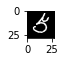

[8]
[9.]


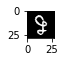

[9]
[0.]


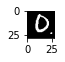

[9]
[0.]


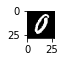

[6]
[5.]


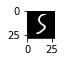

[2]
[6.]


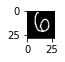

[4]
[5.]


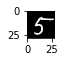

[1]
[7.]


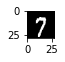

[4]
[6.]


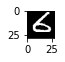

[5]
[9.]


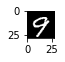

[3]
[7.]


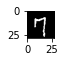

[9]
[4.]


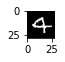

[2]
[5.]


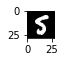

[4]
[5.]


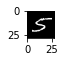

[8]
[7.]


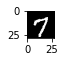

[3]
[0.]


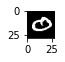

[5]
[1.]


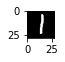

[2]
[6.]


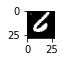

[7]
[6.]


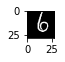

[8]
[7.]


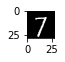

[3]
[8.]


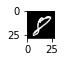

[4]
[7.]


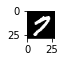

[8]
[9.]


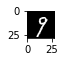

[6]
[9.]


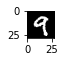

[5]
[1.]


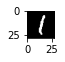

[0]
[6.]


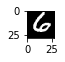

[8]
[1.]


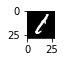

[8]
[0.]


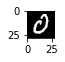

[3]
[9.]


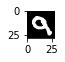

[1]
[0.]


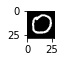

[5]
[4.]


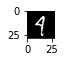

[3]
[1.]


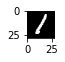

[6]
[4.]


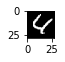

[9]
[2.]


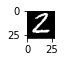

[8]
[2.]


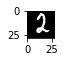

[6]
[8.]


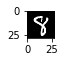

[0]
[6.]


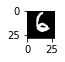

[2]
[0.]


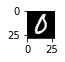

[6]
[7.]


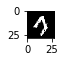

[9]
[7.]


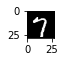

[2]
[8.]


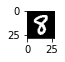

[1]
[2.]


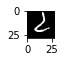

[9]
[6.]


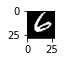

[4]
[8.]


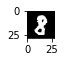

[6]
[5.]


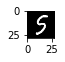

[3]
[7.]


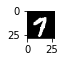

[8]
[1.]


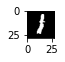

[1]
[6.]


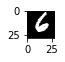

[2]
[6.]


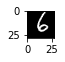

[6]
[9.]


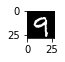

[4]
[6.]


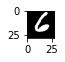

[7]
[3.]


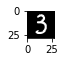

[6]
[2.]


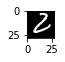

[9]
[2.]


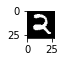

[9]
[6.]


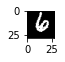

[9]
[0.]


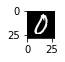

[1]
[0.]


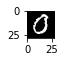

[0]
[2.]


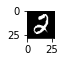

[9]
[7.]


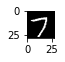

[7]
[9.]


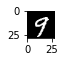

[5]
[6.]


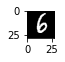

[5]
[3.]


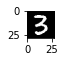

[6]
[2.]


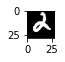

[7]
[9.]


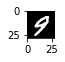

[6]
[9.]


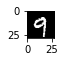

[9]
[1.]


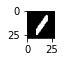

[9]
[0.]


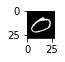

[9]
[5.]


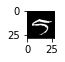

[4]
[3.]


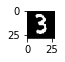

[2]
[3.]


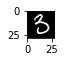

[6]
[2.]


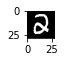

[4]
[2.]


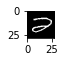

[2]
[1.]


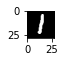

[3]
[4.]


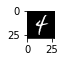

[7]
[6.]


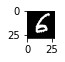

[6]
[4.]


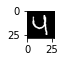

[0]
[2.]


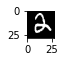

[9]
[4.]


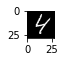

[8]
[7.]


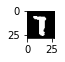

[8]
[1.]


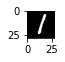

[5]
[4.]


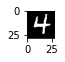

[4]
[1.]


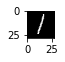

[7]
[9.]


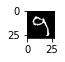

[0]
[7.]


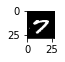

[2]
[3.]


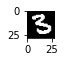

[7]
[5.]


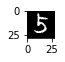

[4]
[3.]


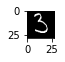

[1]
[9.]


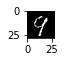

[1]
[4.]


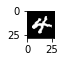

[2]
[9.]


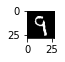

[7]
[2.]


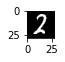

[0]
[6.]


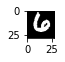

[8]
[6.]


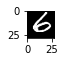

[4]
[6.]


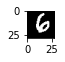

[4]
[2.]


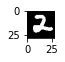

[0]
[5.]


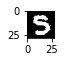

[0]
[2.]


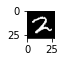

[0]
[9.]


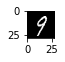

[7]
[1.]


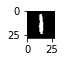

[3]
[5.]


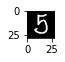

[5]
[4.]


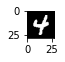

[7]
[6.]


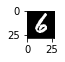

[5]
[8.]


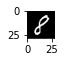

[3]
[6.]


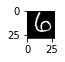

[3]
[4.]


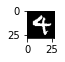

[7]
[8.]


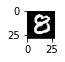

[2]
[1.]


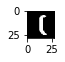

[1]
[7.]


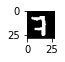

[4]
[6.]


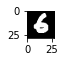

[6]
[5.]


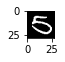

[6]
[3.]


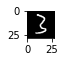

[9]
[3.]


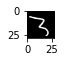

[8]
[2.]


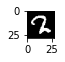

[9]
[1.]


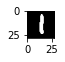

[3]
[6.]


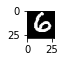

[9]
[8.]


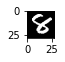

[5]
[3.]


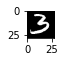

[9]
[1.]


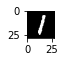

[1]
[2.]


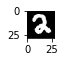

[8]
[6.]


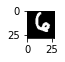

[6]
[4.]


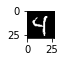

[7]
[4.]


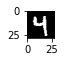

[2]
[3.]


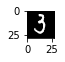

[6]
[5.]


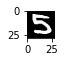

[4]
[1.]


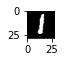

[6]
[3.]


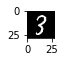

[5]
[4.]


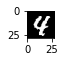

[9]
[5.]


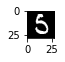

[7]
[1.]


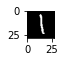

[6]
[3.]


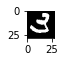

[9]
[7.]


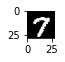

[5]
[6.]


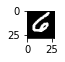

[4]
[0.]


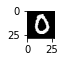

[3]
[9.]


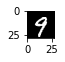

[4]
[1.]


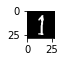

[0]
[1.]


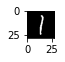

[9]
[0.]


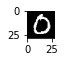

[3]
[1.]


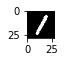

[4]
[8.]


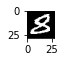

[8]
[9.]


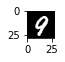

[0]
[4.]


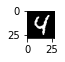

[6]
[9.]


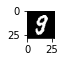

[1]
[8.]


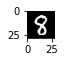

[2]
[4.]


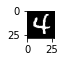

[2]
[4.]


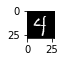

[5]
[4.]


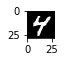

[3]
[4.]


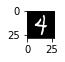

[8]
[9.]


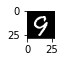

[6]
[2.]


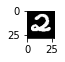

[6]
[8.]


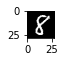

[4]
[6.]


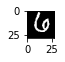

[8]
[1.]


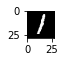

[4]
[0.]


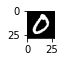

[5]
[8.]


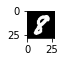

[2]
[5.]


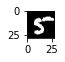

[9]
[5.]


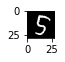

[5]
[3.]


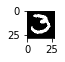

[8]
[9.]


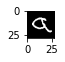

[2]
[8.]


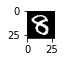

[0]
[9.]


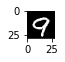

[0]
[5.]


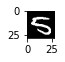

[1]
[4.]


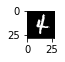

[1]
[8.]


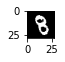

[3]
[9.]


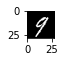

[1]
[2.]


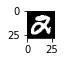

[6]
[1.]


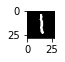

[1]
[0.]


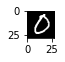

[4]
[6.]


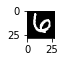

[9]
[1.]


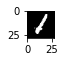

[9]
[1.]


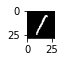

[6]
[4.]


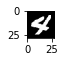

[6]
[9.]


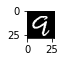

[2]
[3.]


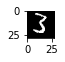

[0]
[4.]


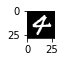

[9]
[0.]


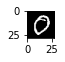

[4]
[1.]


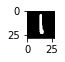

[2]
[7.]


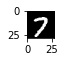

[0]
[9.]


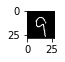

[2]
[6.]


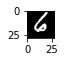

[1]
[6.]


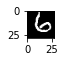

[0]
[6.]


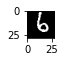

[3]
[0.]


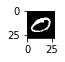

[9]
[1.]


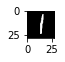

[0]
[2.]


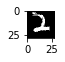

[3]
[4.]


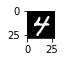

[4]
[8.]


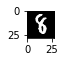

[9]
[1.]


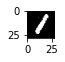

[4]
[1.]


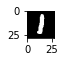

[1]
[0.]


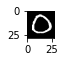

[7]
[1.]


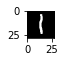

[5]
[8.]


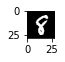

[2]
[1.]


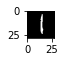

[7]
[3.]


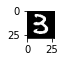

[2]
[9.]


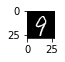

[6]
[0.]


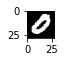

[2]
[4.]


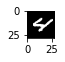

[9]
[5.]


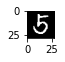

[8]
[3.]


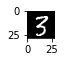

[6]
[8.]


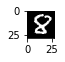

[6]
[4.]


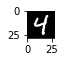

[0]
[2.]


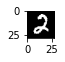

[7]
[0.]


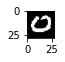

[6]
[7.]


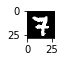

[3]
[2.]


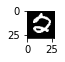

[1]
[7.]


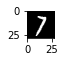

[4]
[7.]


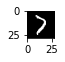

[6]
[8.]


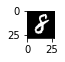

[3]
[6.]


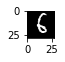

[8]
[7.]


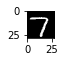

[8]
[4.]


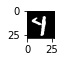

[8]
[2.]


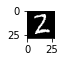

[9]
[4.]


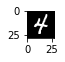

[3]
[8.]


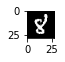

[7]
[3.]


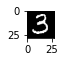

[7]
[1.]


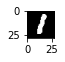

[6]
[7.]


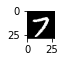

[9]
[4.]


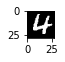

[2]
[1.]


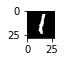

[6]
[8.]


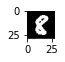

[2]
[8.]


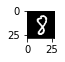

[2]
[3.]


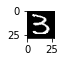

[9]
[0.]


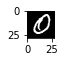

[6]
[1.]


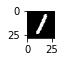

[2]
[7.]


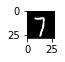

[5]
[7.]


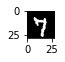

[2]
[9.]


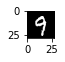

[4]
[6.]


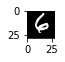

[8]
[0.]


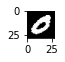

[3]
[8.]


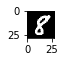

[0]
[4.]


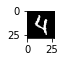

[5]
[6.]


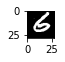

[1]
[9.]


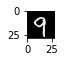

[9]
[6.]


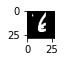

[6]
[2.]


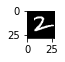

[1]
[2.]


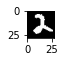

[1]
[9.]


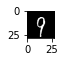

[4]
[1.]


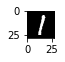

[0]
[1.]


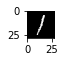

[9]
[2.]


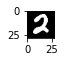

[6]
[5.]


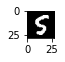

[2]
[6.]


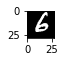

[1]
[4.]


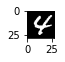

[4]
[2.]


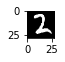

[5]
[8.]


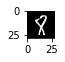

[3]
[5.]


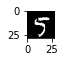

[2]
[6.]


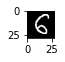

[4]
[9.]


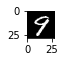

[1]
[2.]


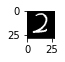

[8]
[1.]


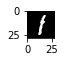

[3]
[4.]


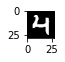

[5]
[6.]


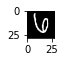

[2]
[0.]


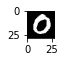

[7]
[3.]


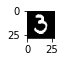

[8]
[0.]


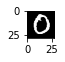

[3]
[9.]


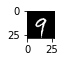

[4]
[7.]


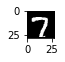

[0]
[9.]


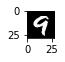

[8]
[7.]


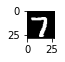

[6]
[3.]


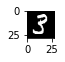

[5]
[8.]


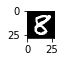

[0]
[6.]


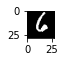

[9]
[5.]


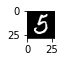

[8]
[6.]


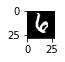

[3]
[5.]


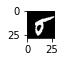

[8]
[0.]


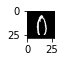

[3]
[7.]


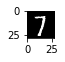

[1]
[2.]


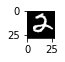

[5]
[0.]


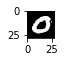

[3]
[1.]


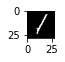

[6]
[1.]


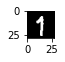

[9]
[3.]


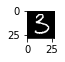

[8]
[9.]


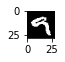

[0]
[4.]


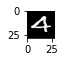

[6]
[2.]


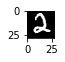

[9]
[8.]


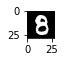

[2]
[9.]


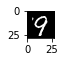

[1]
[9.]


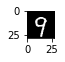

[9]
[1.]


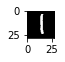

[4]
[5.]


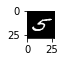

[6]
[5.]


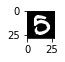

[3]
[8.]


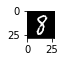

[8]
[5.]


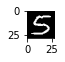

[1]
[3.]


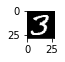

[2]
[4.]


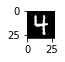

[6]
[2.]


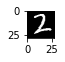

[4]
[6.]


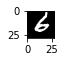

[7]
[9.]


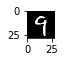

[6]
[0.]


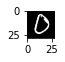

[9]
[1.]


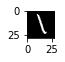

[9]
[6.]


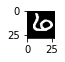

[9]
[2.]


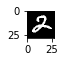

[1]
[8.]


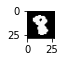

[0]
[2.]


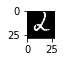

[9]
[0.]


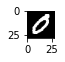

[7]
[9.]


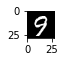

[5]
[3.]


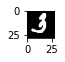

[6]
[4.]


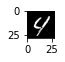

[7]
[8.]


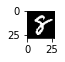

[6]
[5.]


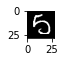

[9]
[5.]


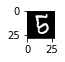

[9]
[7.]


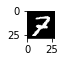

[6]
[8.]


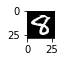

[9]
[7.]


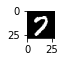

[4]
[3.]


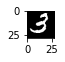

[2]
[4.]


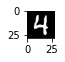

[6]
[0.]


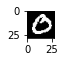

[4]
[7.]


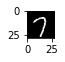

[2]
[0.]


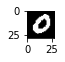

[3]
[2.]


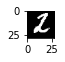

[7]
[3.]


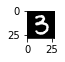

[6]
[4.]


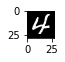

[0]
[1.]


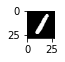

[9]
[8.]


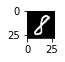

[8]
[3.]


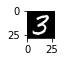

[5]
[9.]


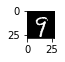

[4]
[8.]


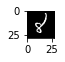

[7]
[9.]


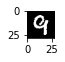

[0]
[9.]


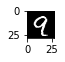

[4]
[6.]


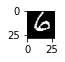

[1]
[7.]


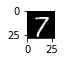

[9]
[1.]


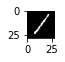

[6]
[3.]


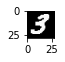

[1]
[8.]


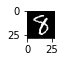

[2]
[7.]


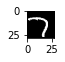

[7]
[2.]


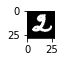

[0]
[7.]


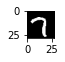

[8]
[7.]


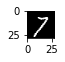

[4]
[3.]


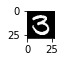

[8]
[3.]


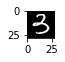

[0]
[3.]


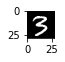

[0]
[1.]


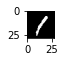

[0]
[7.]


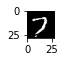

[1]
[0.]


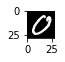

[3]
[0.]


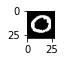

[3]
[9.]


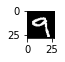

[5]
[8.]


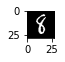

[7]
[1.]


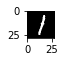

[5]
[9.]


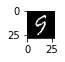

[3]
[7.]


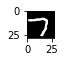

[3]
[9.]


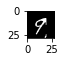

[7]
[0.]


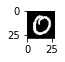

[2]
[5.]


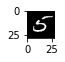

[1]
[0.]


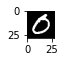

[4]
[9.]


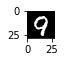

[6]
[5.]


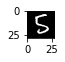

[0]
[7.]


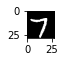

[6]
[8.]


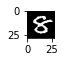

[6]
[3.]


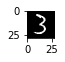

[9]
[3.]


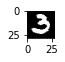

[8]
[2.]


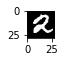

[9]
[0.]


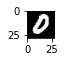

[9]
[0.]


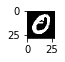

[5]
[7.]


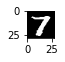

[9]
[3.]


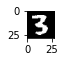

[1]
[9.]


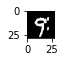

[8]
[5.]


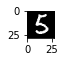

[6]
[4.]


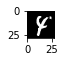

[7]
[8.]


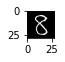

[2]
[8.]


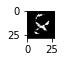

[6]
[2.]


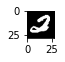

[4]
[1.]


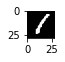

[6]
[7.]


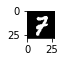

[5]
[0.]


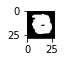

[9]
[5.]


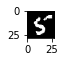

[5]
[6.]


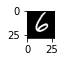

[7]
[5.]


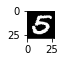

[6]
[5.]


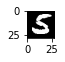

[9]
[5.]


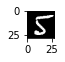

[5]
[1.]


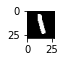

[9]
[6.]


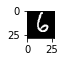

[4]
[7.]


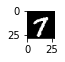

[3]
[7.]


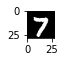

[7]
[5.]


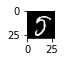

[4]
[1.]


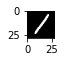

[0]
[3.]


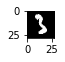

[9]
[6.]


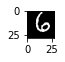

[3]
[0.]


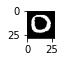

[3]
[1.]


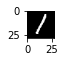

[4]
[2.]


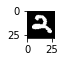

[8]
[3.]


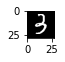

[0]
[5.]


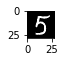

[1]
[2.]


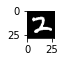

[6]
[5.]


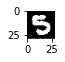

[2]
[4.]


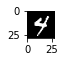

[2]
[9.]


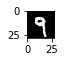

[5]
[8.]


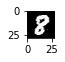

[3]
[2.]


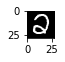

[8]
[1.]


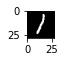

[6]
[0.]


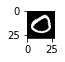

[6]
[2.]


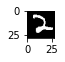

[4]
[7.]


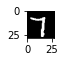

[8]
[9.]


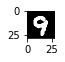

[4]
[7.]


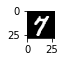

[5]
[2.]


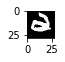

[2]
[3.]


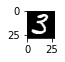

[9]
[1.]


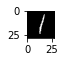

[5]
[4.]


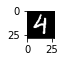

[2]
[3.]


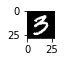

[0]
[7.]


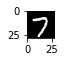

[0]
[7.]


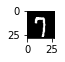

[1]
[9.]


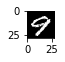

[9]
[8.]


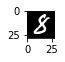

[1]
[8.]


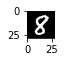

[3]
[0.]


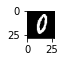

[1]
[4.]


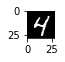

[6]
[2.]


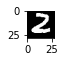

[1]
[3.]


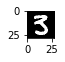

[4]
[7.]


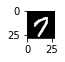

[9]
[2.]


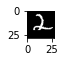

[6]
[8.]


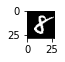

[2]
[8.]


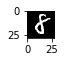

[9]
[2.]


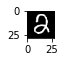

[4]
[3.]


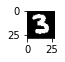

[2]
[9.]


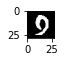

[0]
[6.]


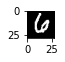

[2]
[5.]


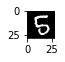

[0]
[3.]


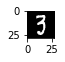

[9]
[6.]


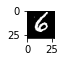

[0]
[8.]


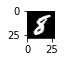

[4]
[2.]


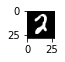

[9]
[2.]


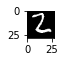

[4]
[6.]


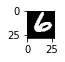

[1]
[4.]


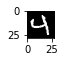

[7]
[9.]


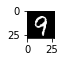

[5]
[8.]


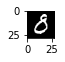

[2]
[1.]


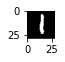

[2]
[7.]


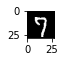

[6]
[4.]


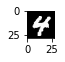

[2]
[6.]


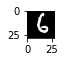

[9]
[7.]


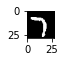

[8]
[2.]


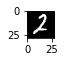

[6]
[8.]


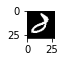

[6]
[9.]


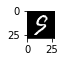

[0]
[4.]


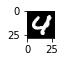

[7]
[0.]


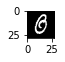

[6]
[2.]


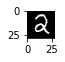

[3]
[7.]


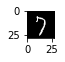

[1]
[6.]


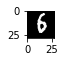

[4]
[2.]


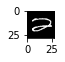

[6]
[0.]


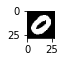

[3]
[7.]


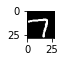

[8]
[5.]


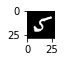

[8]
[1.]


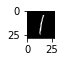

[8]
[1.]


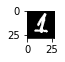

[9]
[3.]


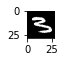

[3]
[6.]


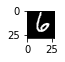

[7]
[8.]


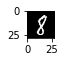

[7]
[6.]


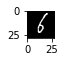

[6]
[2.]


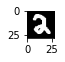

[9]
[0.]


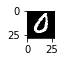

[2]
[4.]


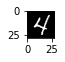

[1]
[4.]


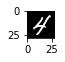

[6]
[9.]


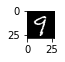

[2]
[5.]


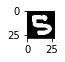

[2]
[1.]


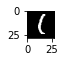

[2]
[6.]


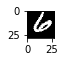

[5]
[3.]


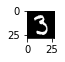

[2]
[3.]


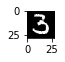

[3]
[0.]


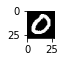

[0]
[3.]


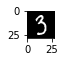

[5]
[6.]


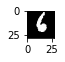

[1]
[0.]


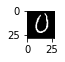

[9]
[7.]


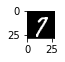

[6]
[5.]


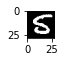

[1]
[4.]


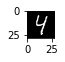

[4]
[0.]


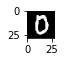

[0]
[6.]


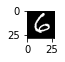

[6]
[2.]


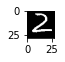

[2]
[5.]


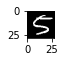

[4]
[1.]


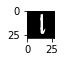

[1]
[7.]


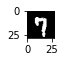

[4]
[1.]


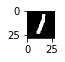

[5]
[4.]


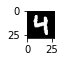

[3]
[1.]


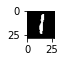

[9]
[1.]


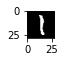

[2]
[9.]


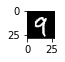

[4]
[1.]


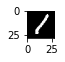

[1]
[6.]


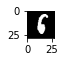

[8]
[9.]


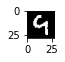

[3]
[9.]


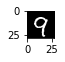

[5]
[3.]


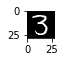

[2]
[6.]


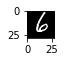

[7]
[8.]


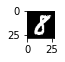

[4]
[2.]


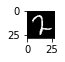

[0]
[4.]


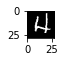

[8]
[4.]


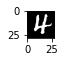

[6]
[7.]


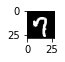

[5]
[4.]


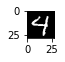

[0]
[2.]


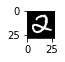

[9]
[1.]


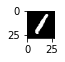

[8]
[4.]


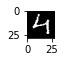

[3]
[1.]


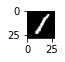

[8]
[2.]


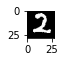

[3]
[7.]


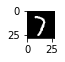

[5]
[2.]


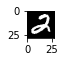

[3]
[5.]


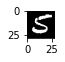

[6]
[4.]


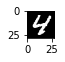

[9]
[1.]


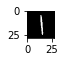

[8]
[6.]


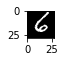

[6]
[9.]


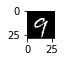

[0]
[2.]


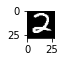

[2]
[5.]


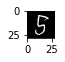

[6]
[0.]


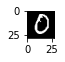

[2]
[4.]


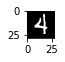

[9]
[7.]


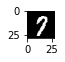

[4]
[1.]


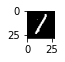

[6]
[3.]


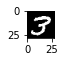

[8]
[3.]


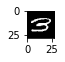

[1]
[5.]


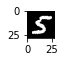

[2]
[8.]


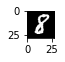

[6]
[8.]


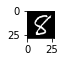

[7]
[9.]


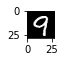

[6]
[7.]


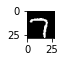

[9]
[8.]


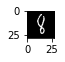

[9]
[4.]


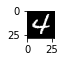

[9]
[3.]


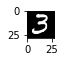

[1]
[9.]


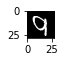

[0]
[5.]


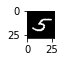

[9]
[7.]


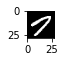

[7]
[3.]


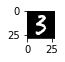

[7]
[3.]


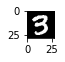

[6]
[1.]


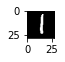

[9]
[8.]


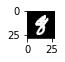

[9]
[6.]


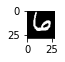

[6]
[2.]


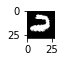

[9]
[1.]


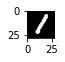

[4]
[3.]


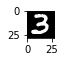

[2]
[1.]


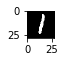

[4]
[3.]


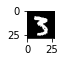

[2]
[0.]


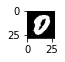

[3]
[2.]


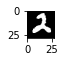

[6]
[1.]


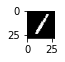

[0]
[9.]


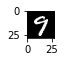

[9]
[1.]


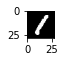

[8]
[3.]


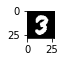

[8]
[3.]


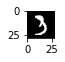

[5]
[3.]


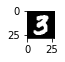

[4]
[7.]


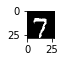

[7]
[3.]


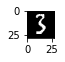

[2]
[8.]


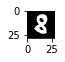

[7]
[8.]


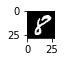

[4]
[6.]


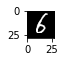

[1]
[4.]


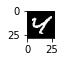

[9]
[0.]


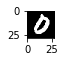

[6]
[2.]


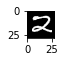

[1]
[6.]


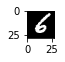

[2]
[9.]


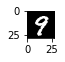

[0]
[7.]


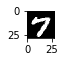

[8]
[5.]


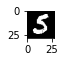

[4]
[8.]


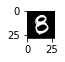

[8]
[7.]


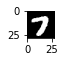

[0]
[4.]


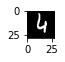

[0]
[4.]


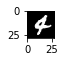

[0]
[9.]


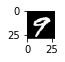

[7]
[3.]


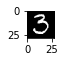

[1]
[9.]


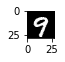

[3]
[8.]


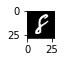

[3]
[7.]


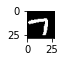

[5]
[7.]


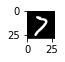

[7]
[9.]


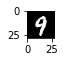

[5]
[0.]


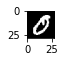

[3]
[9.]


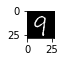

[3]
[1.]


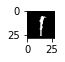

[7]
[8.]


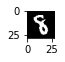

[2]
[8.]


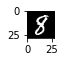

[1]
[3.]


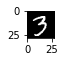

[4]
[0.]


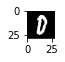

[0]
[3.]


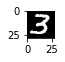

[6]
[4.]


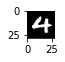

[6]
[3.]


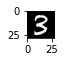

[9]
[1.]


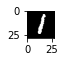

[9]
[1.]


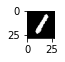

[3]
[9.]


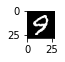

[9]
[5.]


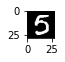

[5]
[9.]


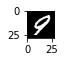

[9]
[3.]


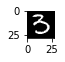

[1]
[0.]


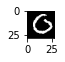

[6]
[9.]


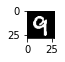

[7]
[4.]


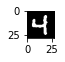

[2]
[7.]


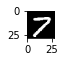

[6]
[4.]


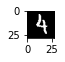

[4]
[8.]


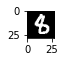

[3]
[5.]


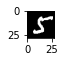

[6]
[4.]


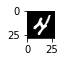

[5]
[2.]


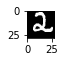

[9]
[3.]


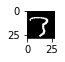

[5]
[4.]


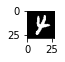

[7]
[1.]


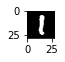

[6]
[0.]


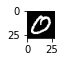

[5]
[6.]


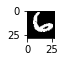

[9]
[6.]


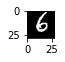

[4]
[7.]


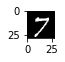

[3]
[6.]


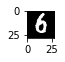

[7]
[9.]


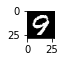

[4]
[0.]


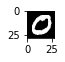

[0]
[3.]


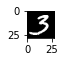

[9]
[1.]


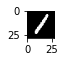

[3]
[6.]


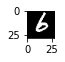

[3]
[6.]


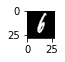

[4]
[1.]


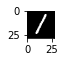

[8]
[3.]


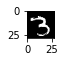

[0]
[3.]


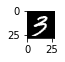

[1]
[0.]


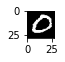

[6]
[7.]


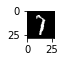

[1]
[5.]


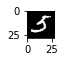

[2]
[6.]


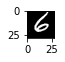

[5]
[8.]


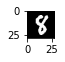

[3]
[4.]


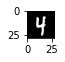

[8]
[6.]


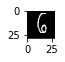

[6]
[3.]


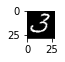

[6]
[2.]


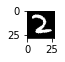

[4]
[5.]


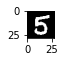

[8]
[0.]


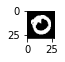

[4]
[0.]


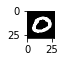

[5]
[9.]


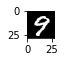

[2]
[4.]


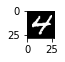

[9]
[3.]


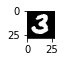

[5]
[2.]


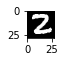

[8]
[4.]


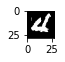

[0]
[7.]


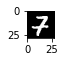

[0]
[3.]


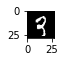

[1]
[0.]


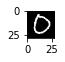

[9]
[8.]


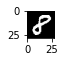

[1]
[6.]


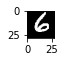

[3]
[9.]


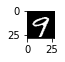

[1]
[4.]


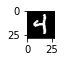

[6]
[7.]


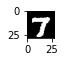

[4]
[9.]


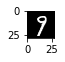

[9]
[1.]


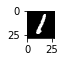

[6]
[8.]


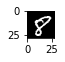

[6]
[0.]


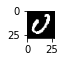

[2]
[9.]


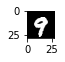

[0]
[6.]


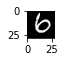

[9]
[5.]


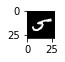

[4]
[6.]


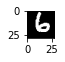

[2]
[4.]


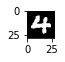

[0]
[5.]


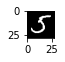

[2]
[8.]


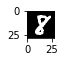

[1]
[4.]


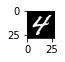

[0]
[9.]


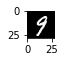

[3]
[7.]


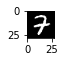

[9]
[6.]


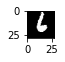

[0]
[7.]


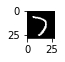

[3]
[5.]


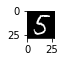

[4]
[8.]


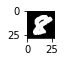

[9]
[3.]


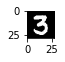

[4]
[2.]


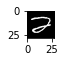

[1]
[8.]


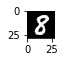

[7]
[2.]


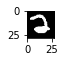

[7]
[1.]


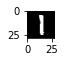

[2]
[3.]


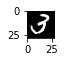

[6]
[9.]


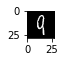

[2]
[3.]


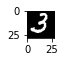

[8]
[0.]


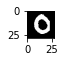

[6]
[1.]


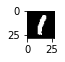

[6]
[7.]


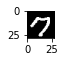

[0]
[8.]


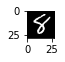

[7]
[4.]


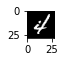

[6]
[5.]


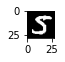

[3]
[1.]


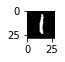

[4]
[1.]


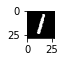

[6]
[5.]


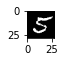

[3]
[7.]


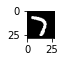

[8]
[5.]


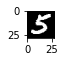

[8]
[6.]


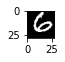

[8]
[5.]


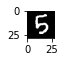

[9]
[8.]


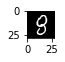

[3]
[4.]


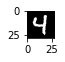

[7]
[9.]


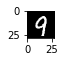

[7]
[4.]


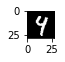

[6]
[7.]


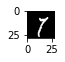

[9]
[7.]


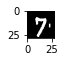

In [128]:
#print(flat[:50],y_test[:50])
#print(y_test[:50])
for i in range(1000):
    if (flat[i] != y_test[i]):
        print(flat[i])
        print(y_test[i])
        plt.figure(figsize=(0.50,0.50))
        plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
        plt.show()

In [118]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=flat)
print(conf_matrix)

print(sum(y_test == 1))
print(sum(flat == 1))

[[162 101 123 117 102  89 183  86  88 165]
 [135 183 122 127 146 115 177 125  96 214]
 [107 118 176 106 114  97 165 121  93 152]
 [131 122 127 166 116 104 206 112  91 168]
 [107 122 123 113 163  97 178  88  85 160]
 [109  94  88  90  91 113 171  80  85 159]
 [109 112 110  99 114 111 236 109  91 153]
 [125 129 116 106 128  79 188 176 106 174]
 [ 91 113 123 103 117  98 182  95 152 163]
 [107 118 125  90 107  89 154 112  92 235]]
[1440]
[1212]
